In [89]:
import sys, platform

base_path = '/home/yurid/git/tcc'

if platform.system() == 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [90]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.impute import KNNImputer
import src.filler as fl
from src.filler import RandomForestFillerWithOneModel, LstmFillerModel, HodmdFiller, Debbuger
from src.dataframe import read_data_from_csv, show_error_metrics, split_data, windowing_nparray

In [91]:
filename = f'{base_path}/data/daily_vicosa.csv'

In [92]:
df = read_data_from_csv(filename)

df = df.RADIATION

In [93]:
data = fl.FillerHelper.get_largest_complete_interval(df)
data_with_gaps = fl.FillerHelper.introduce_gaps(data.copy(), 
                                                missing_percentage=0.1, 
                                                min_gap_size=1, 
                                                max_gap_size=4)

3839
714
Percentual de dados faltantes: 0.1859859338369367


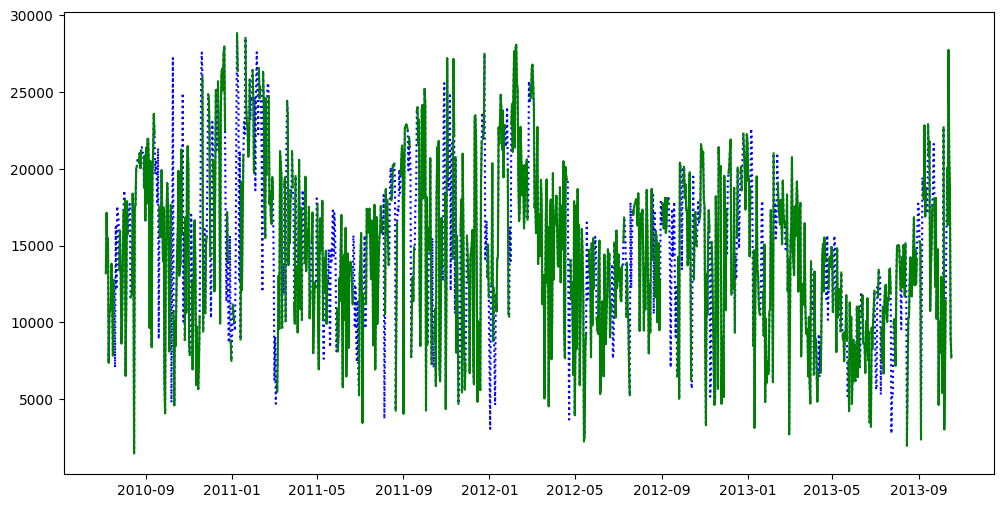

In [94]:
maxrange = 1200

print(len(data))
print(data_with_gaps.isna().sum())
print('Percentual de dados faltantes:', (data_with_gaps.isna().sum()/len(data)))

pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_with_gaps[0:maxrange], color='green', label='missing_data')
pyplot.show()

DMD

In [95]:
def objective(trial):
    dmd_data = data_with_gaps.copy()
    filler = fl.HodmdFiller(d_factor=trial.suggest_float("d_fator", 0.5, 0.99, log=True))
    data_filled = filler.dmd_filler(dmd_data)
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    return mae


study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'hodmd',
    load_if_exists=True
)

n_trials = 8
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 11:11:26,120] Using an existing study with name 'hodmd' instead of creating a new one.


Number of finished trials: 15
Best trial:
  Value: 1552.2483310419966
  Params: 
    d_fator: 0.8450333686112531
    factor: 0.8138850095355864


Interpolation Seasonal

In [96]:
def objective(trial):
    data_filled = fl.seasonal_filler(data_with_gaps.copy(), 
                                     period=trial.suggest_int("period", 24, 365, log=True), 
                                     factor=trial.suggest_int("factor", 1, 6, log=True))
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    print('Faltantes SCORE:', data_filled.isna().sum())
    return mae



study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'interpolation_seasonal_new',
    load_if_exists=True
)

n_trials = 100
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 11:11:26,208] Using an existing study with name 'interpolation_seasonal_new' instead of creating a new one.


Number of finished trials: 160
Best trial:
  Value: 1589.9163320628968
  Params: 
    period: 347
    factor: 6


Random forest

In [97]:
def objective(trial):
    rf_data = data_with_gaps.copy()
    filler_model = RandomForestFillerWithOneModel(
        n_estimators=trial.suggest_int("estimators", 100, 5000, log=True), 
        n_in=trial.suggest_int("n_in", 1, 15, log=True), 
        n_out=1)
    data_filled = filler_model.filler(rf_data)
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    print('Faltantes SCORE:', data_filled.isna().sum())
    return mae



study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'random_forest',
    load_if_exists=True
)

n_trials = 40
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 11:11:26,333] Using an existing study with name 'random_forest' instead of creating a new one.


Number of finished trials: 44
Best trial:
  Value: 896.0714458131623
  Params: 
    estimators: 1762
    n_in: 3


In [98]:
def windowing_nparray(values, step_back, step_front) -> (np.array, np.array):
    x, y = [], []
    for i in range(len(values) - step_back - step_front):
        j = (i + step_back)
        x.append(values[i:j])
        y.append(values[j:(j+step_front), 0])

    return np.array(x), np.array(y)

def knn_filler(data, k):
    imputer = KNNImputer(n_neighbors=k)
    filled_data_knn = imputer.fit_transform(data.values.reshape(-1,1))
    return pd.Series(filled_data_knn.ravel(), name=data.name, index=data.index.values)

def train_model(train_x, train_y, is_debug):
    model = Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_x.shape[2])),
        LSTM(units=350, return_sequences=True),
        Dropout(0.2),
        LSTM(units=350),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())

    Debbuger.log(is_debug, 'Model Summary', model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

    history = model.fit(train_x,
                        train_y,
                        epochs=5000,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=[es],
                        workers=4,
                        use_multiprocessing=True)

    # plot history
    if is_debug:
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

    return model

In [99]:
step_back = 10
ratio = 0.9

scaler = MinMaxScaler(feature_range=(0,1))

data_scaled = scaler.fit_transform(data.values.reshape(-1,1))

X, Y = windowing_nparray(data_scaled, step_back=step_back, step_front=1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(data_scaled), ratio=ratio)

real_test_y = scaler.inverse_transform(test_y.reshape(-1,1))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout (Dropout)           (None, 10, 350)           0         
                                                                 
 lstm_24 (LSTM)              (None, 350)               981400    
                                                                 
 dense_23 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping


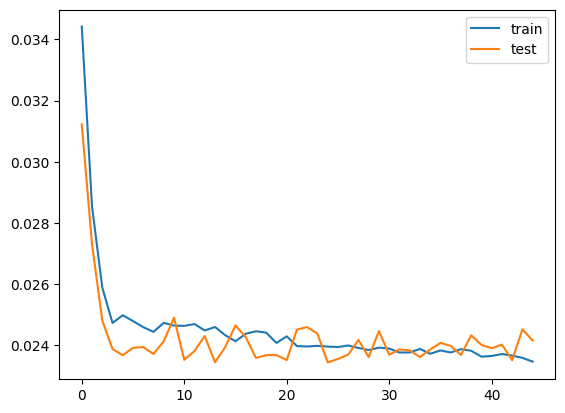

12/12 [==============================] - 1s 5ms/step
Forecasting
Test R2: 0.317
Test MSE: 21943025.719
Test RMSE: 4684.338
Test MAE: 3685.969
Test MAPE: 0.353


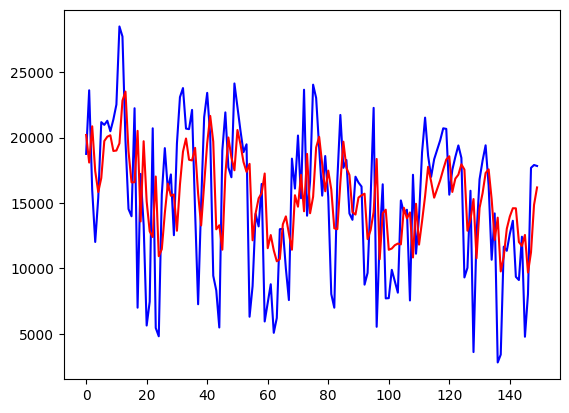

In [100]:
#Treinando model
model = train_model(train_x, train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: -0.638
Test MSE: 56335038.670
Test RMSE: 7505.667
Test MAE: 3040.863
Test MAPE: 0.186


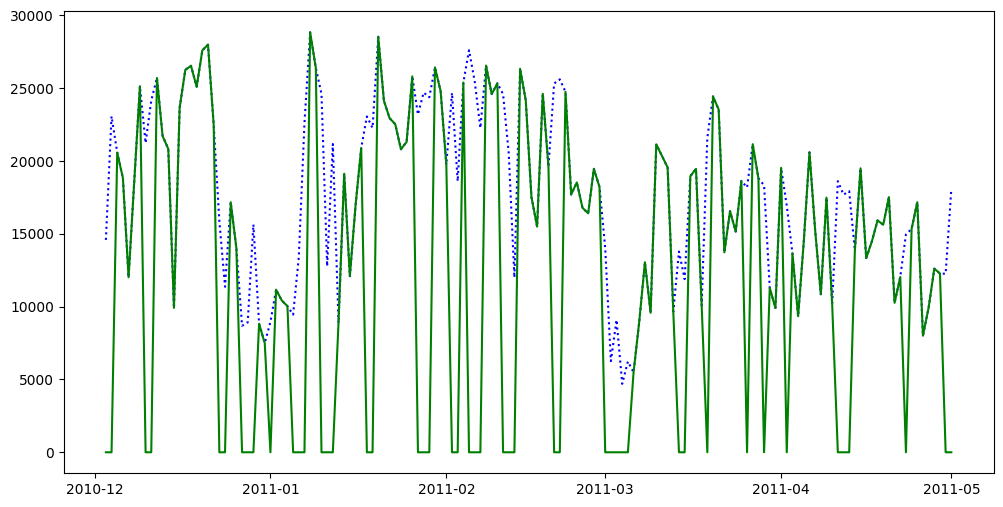

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout_1 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_26 (LSTM)              (None, 350)               981400    
                                                                 
 dense_24 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 23.
Epoch 43: early stopping


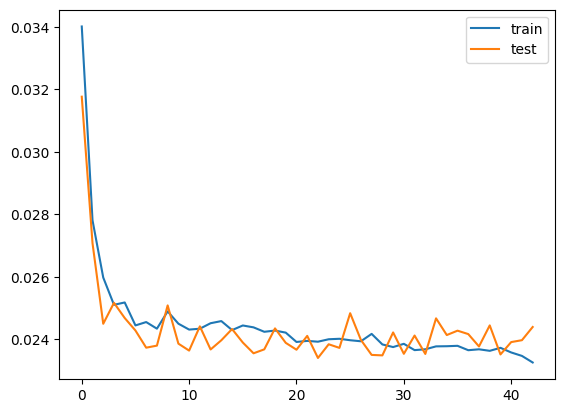

12/12 [==============================] - 1s 5ms/step
Forecasting
Test R2: 0.327
Test MSE: 21623763.416
Test RMSE: 4650.136
Test MAE: 3620.552
Test MAPE: 0.349


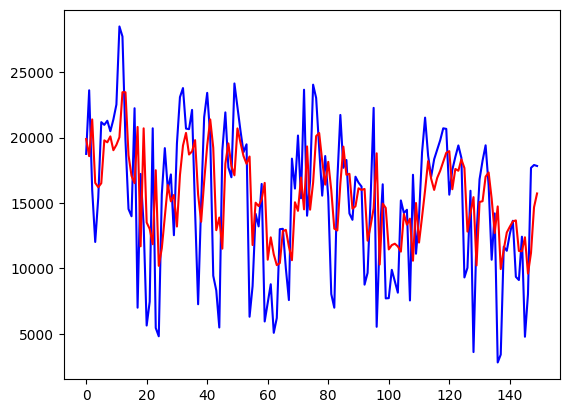

In [101]:
# Completa
data_gaps = data_with_gaps.copy()
data_gaps_filled = data_gaps.fillna(0)

# Métricas
print('Input metrics')
show_error_metrics(data, data_gaps_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_gaps_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
data_gaps_scaled = scaler.transform(data_gaps_filled.values.reshape(-1,1))
gaps_X, gaps_Y = windowing_nparray(data_gaps_scaled, step_back=step_back, step_front=1)
gaps_train_x, gaps_train_y, gaps_test_x, gaps_test_y = split_data(X, Y, length=len(data_gaps_scaled), ratio=ratio)

#Treinando model
model = train_model(gaps_train_x, gaps_train_y, True)
predict = model.predict(gaps_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

(3839, 1)


/home/yurid/miniconda3/envs/tf/lib/python3.9/site-packages/pydmd/hodmd.py:140: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn(
/home/yurid/miniconda3/envs/tf/lib/python3.9/site-packages/pydmd/utils.py:35: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(


DMDFiller -> Dados Faltantes: 0
Input metrics
Test R2: 0.212
Test MSE: 27107094.154
Test RMSE: 5206.447
Test MAE: 1186.255
Test MAPE: 0.097


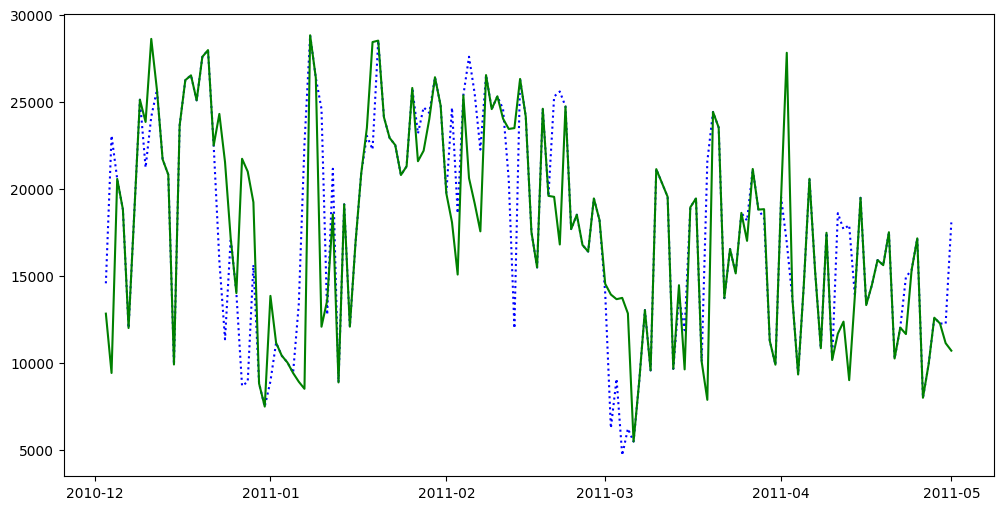

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_28 (LSTM)              (None, 350)               981400    
                                                                 
 dense_25 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 19.
Epoch 39: early stopping


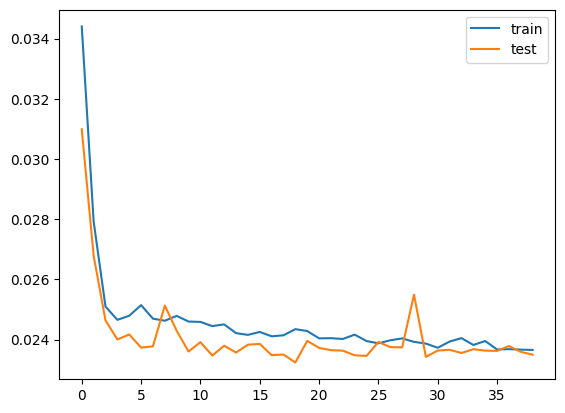

12/12 [==============================] - 1s 31ms/step
Forecasting
Test R2: 0.325
Test MSE: 21709626.273
Test RMSE: 4659.359
Test MAE: 3620.475
Test MAPE: 0.348


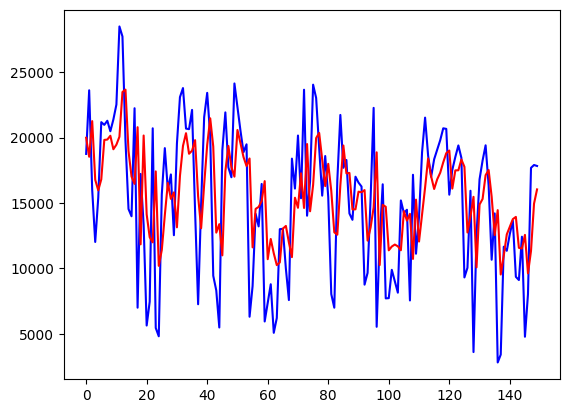

In [102]:
# Completa
dmd_data = data_with_gaps.copy()
filler = fl.HodmdFiller(d_factor=0.99)
data_filled = filler.dmd_filler(dmd_data)

# Métricas
print('Input metrics')
show_error_metrics(data, data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
dmd_data_scaled = scaler.transform(data_filled.values.reshape(-1,1))
dmd_X, dmd_Y = windowing_nparray(dmd_data_scaled, step_back=step_back, step_front=1)
dmd_train_x, dmd_train_y, dmd_test_x, dmd_test_y = split_data(X, Y, length=len(dmd_data_scaled), ratio=ratio)

#Treinando model
model = train_model(dmd_train_x, dmd_train_y, True)
predict = model.predict(dmd_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

714
Input metrics
Test R2: 0.430
Test MSE: 19616576.634
Test RMSE: 4429.060
Test MAE: 1573.087
Test MAPE: 0.102


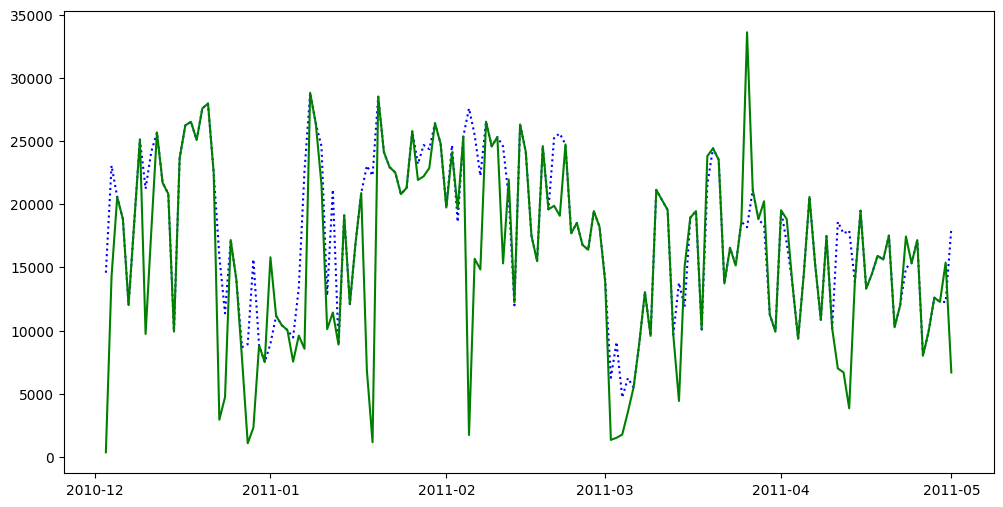

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout_3 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_30 (LSTM)              (None, 350)               981400    
                                                                 
 dense_26 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 34.
Epoch 54: early stopping


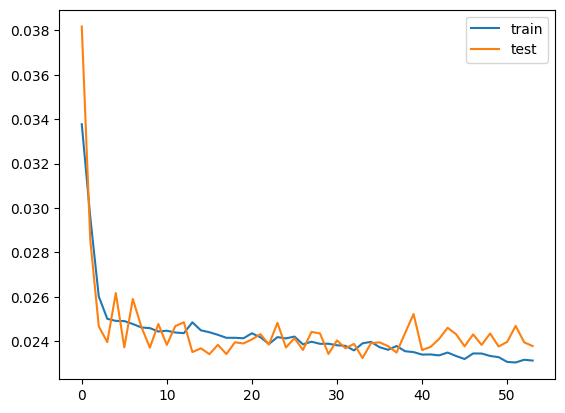

12/12 [==============================] - 1s 31ms/step
Forecasting
Test R2: 0.331
Test MSE: 21498145.237
Test RMSE: 4636.609
Test MAE: 3660.100
Test MAPE: 0.344


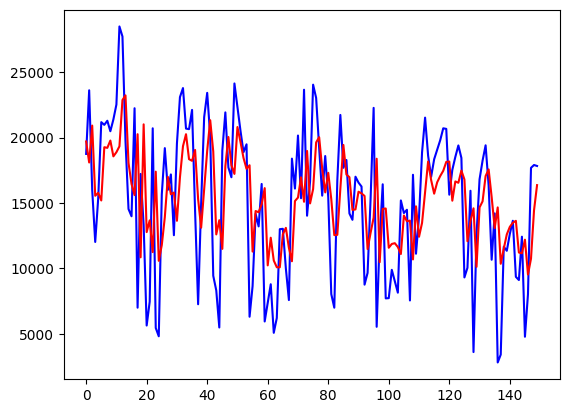

In [103]:
# Completa
seasonal_data = data_with_gaps.copy()
seasonal_data_filled = fl.seasonal_filler(seasonal_data, 
                                            period=347, 
                                            factor=6)

# Métricas
print('Input metrics')
show_error_metrics(data, seasonal_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(seasonal_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
seasonal_data_scaled = scaler.transform(seasonal_data_filled.values.reshape(-1,1))
seasonal_X, seasonal_Y = windowing_nparray(seasonal_data_scaled, step_back=step_back, step_front=1)
seasonal_train_x, seasonal_train_y, seasonal_test_x, seasonal_test_y = split_data(X, Y, length=len(seasonal_data_scaled), ratio=ratio)

#Treinando model
model = train_model(seasonal_train_x, seasonal_train_y, True)
predict = model.predict(seasonal_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.818
Test MSE: 6267273.718
Test RMSE: 2503.452
Test MAE: 855.190
Test MAPE: 0.072


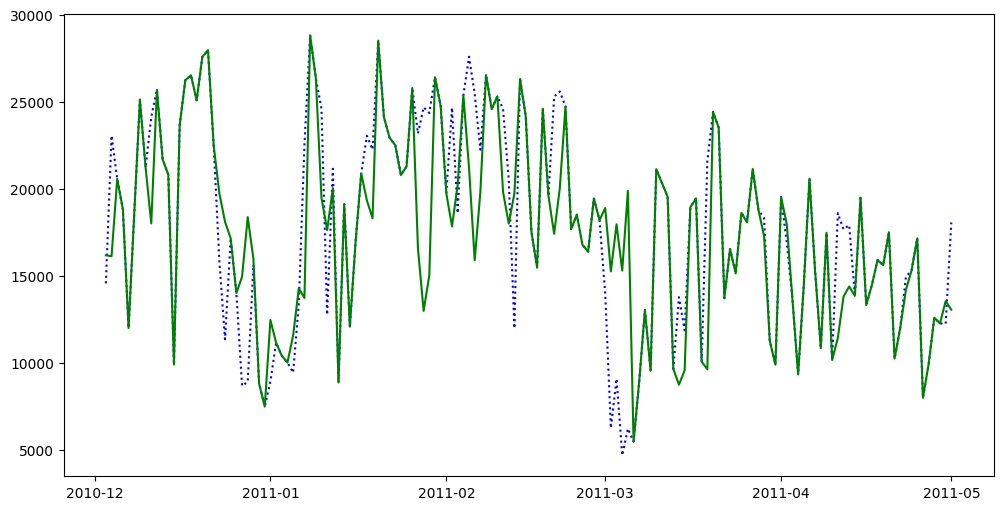

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout_4 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_32 (LSTM)              (None, 350)               981400    
                                                                 
 dense_27 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 24.
Epoch 44: early stopping


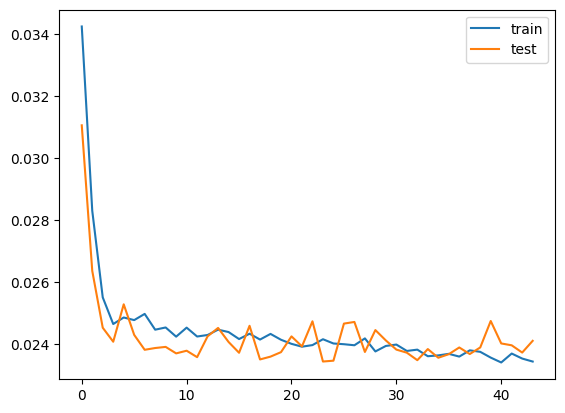

12/12 [==============================] - 1s 25ms/step
Forecasting
Test R2: 0.327
Test MSE: 21645150.724
Test RMSE: 4652.435
Test MAE: 3687.154
Test MAPE: 0.348


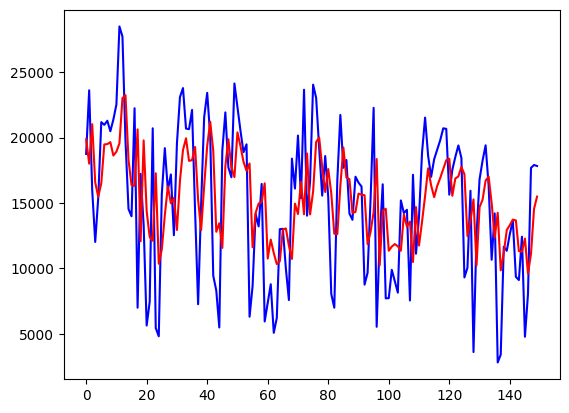

In [104]:
# Completa
rf_data = data_with_gaps.copy()
filler_model = RandomForestFillerWithOneModel(
    n_estimators=1500, 
    n_in=3, 
    n_out=1)
rf_data_filled = filler_model.filler(rf_data)

# Métricas
print('Input metrics')
show_error_metrics(data, rf_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(rf_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
rf_data_scaled = scaler.transform(rf_data_filled.values.reshape(-1,1))
rf_X, rf_Y = windowing_nparray(rf_data_scaled, step_back=step_back, step_front=1)
rf_train_x, rf_train_y, rf_test_x, rf_test_y = split_data(X, Y, length=len(rf_data_scaled), ratio=ratio)

#Treinando model
model = train_model(rf_train_x, rf_train_y, True)
predict = model.predict(rf_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.878
Test MSE: 4198468.774
Test RMSE: 2049.017
Test MAE: 664.309
Test MAPE: 0.058


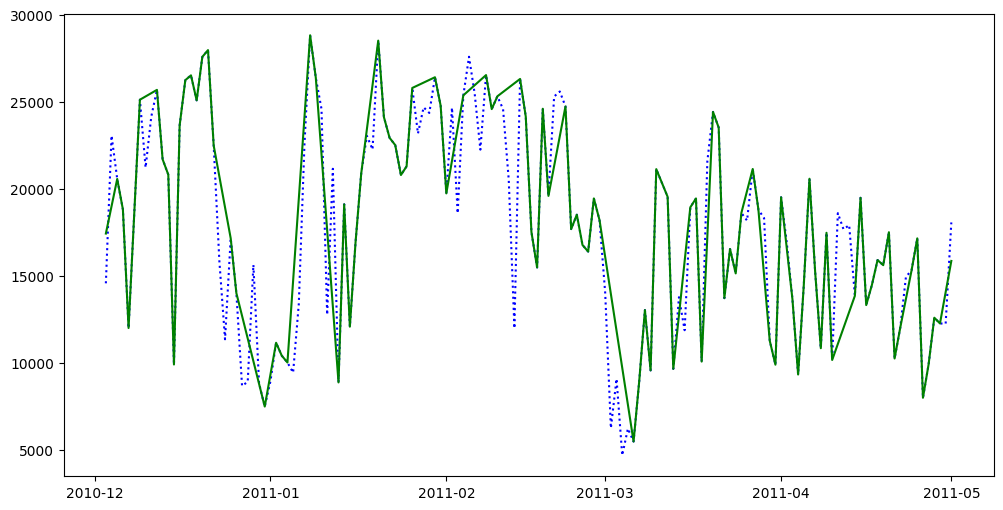

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout_5 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_34 (LSTM)              (None, 350)               981400    
                                                                 
 dense_28 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 37.
Epoch 57: early stopping


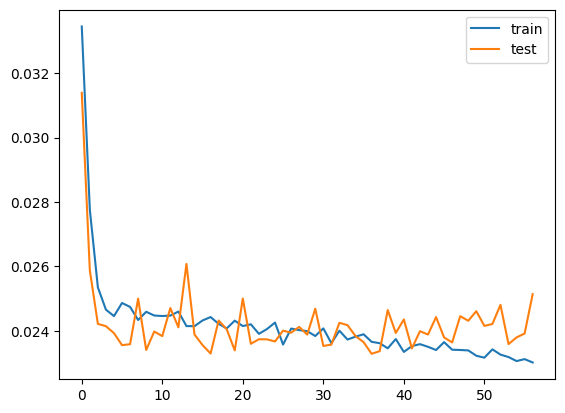

12/12 [==============================] - 1s 6ms/step
Forecasting
Test R2: 0.331
Test MSE: 21511239.914
Test RMSE: 4638.021
Test MAE: 3688.012
Test MAPE: 0.346


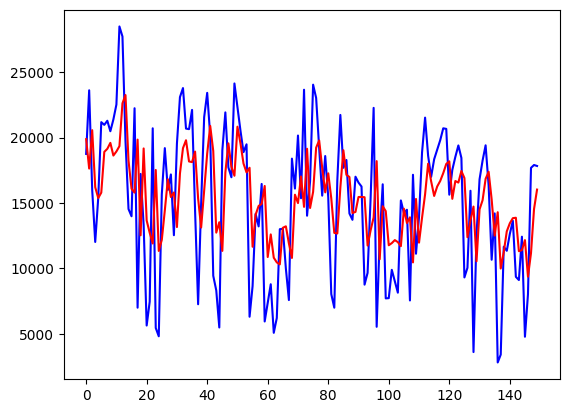

In [105]:
# Completa
interpolate_data = data_with_gaps.copy()
interpolate_data_filled = interpolate_data.interpolate(method='linear')

# Métricas
print('Input metrics')
show_error_metrics(data, interpolate_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(interpolate_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
interpolate_data_scaled = scaler.transform(interpolate_data_filled.values.reshape(-1,1))
interpolate_X, interpolate_Y = windowing_nparray(interpolate_data_scaled, step_back=step_back, step_front=1)
interpolate_train_x, interpolate_train_y, interpolate_test_x, interpolate_test_y = split_data(X, Y, length=len(interpolate_data_scaled), ratio=ratio)

#Treinando model
model = train_model(interpolate_train_x, interpolate_train_y, True)
predict = model.predict(interpolate_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.807
Test MSE: 6636845.057
Test RMSE: 2576.207
Test MAE: 895.760
Test MAPE: 0.078


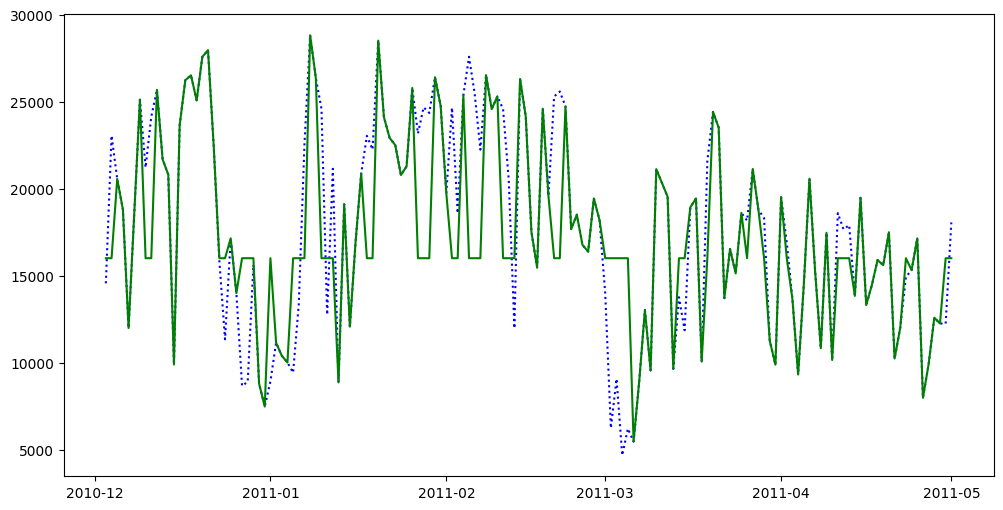

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 10, 350)           492800    
                                                                 
 dropout_6 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_36 (LSTM)              (None, 350)               981400    
                                                                 
 dense_29 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1474551 (5.62 MB)
Trainable params: 1474551 (5.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 26.
Epoch 46: early stopping


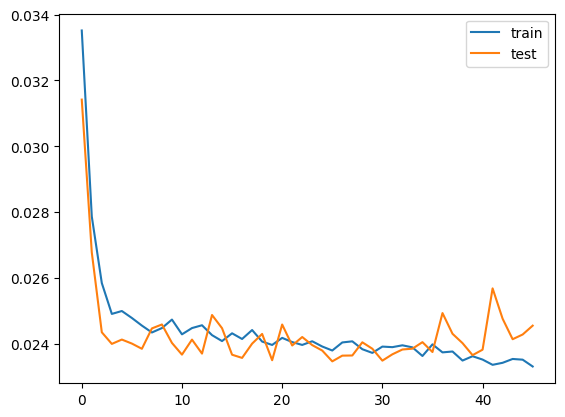

12/12 [==============================] - 1s 34ms/step
Forecasting
Test R2: 0.335
Test MSE: 21376981.752
Test RMSE: 4623.525
Test MAE: 3606.207
Test MAPE: 0.348


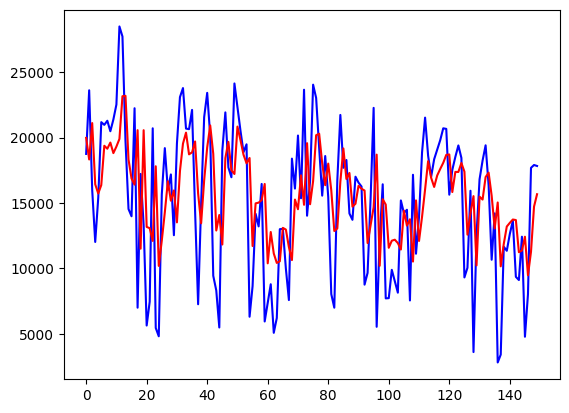

In [106]:
# Completa
knn_data = data_with_gaps.copy()
knn_data_filled = knn_filler(knn_data, k=5)

# Métricas
print('Input metrics')
show_error_metrics(data, knn_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(knn_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
knn_data_scaled = scaler.transform(knn_data_filled.values.reshape(-1,1))
knn_X, knn_Y = windowing_nparray(knn_data_scaled, step_back=step_back, step_front=1)
knn_train_x, knn_train_y, knn_test_x, knn_test_y = split_data(X, Y, length=len(knn_data_scaled), ratio=ratio)

#Treinando model
model = train_model(knn_train_x, knn_train_y, True)
predict = model.predict(knn_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()